In [1]:
# !pip install -e /home/jovyan/development/verde/

In [2]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
import seaborn as sn
import verde as vd
import xarray as xr
from cartopy.crs import Projection
from pyproj import CRS
from rasterstats import zonal_stats

plt.style.use("ggplot")

In [3]:
class ProjectCustomExtent(Projection):
    """Class to override projection extent limits for Cartopy plots.
    See https://stackoverflow.com/a/71543459/505698 for details.
    """

    def __init__(self, epsg, extent):
        self.xmin, self.xmax, self.ymin, self.ymax = extent
        super().__init__(CRS.from_epsg(epsg).to_string())

    @Projection.boundary.getter
    def boundary(self):
        coords = (
            (self.x_limits[0], self.y_limits[0]),
            (self.x_limits[0], self.y_limits[1]),
            (self.x_limits[1], self.y_limits[1]),
            (self.x_limits[1], self.y_limits[0]),
        )
        return ccrs.sgeom.LineString(coords)

    @Projection.x_limits.getter
    def x_limits(self):
        return self.xmin, self.xmax

    @Projection.y_limits.getter
    def y_limits(self):
        return self.ymin, self.ymax

# Task 2.7: Improve workflow for non-agricultural diffuse inputs

## Part B: Spatial interpolation for "skog" and "fjell" areas

From the proposal text:

> **Oppgave 2.7: Forbedre arbeidsflyten for ikke-jordbruk diffuse kilder**
> 
> NIVAs eksisterende database over punktutslipp vil bli kombinert med 2019 «1000 Innsjøer» datasettet (Hindar et al., 2020) for å identifisere overvannssjøer med liten eller ingen direkte menneskeskapt tilførsel. Dette datasettet vil bli ytterligere delt inn i to grupper (skog og fjell) basert på dominerende arealdekke, stort sett etter den opprinnelige TEOTIL arbeidsflyten. Romlig interpolering av disse datasettene (potensielt ved bruk av NDVI som en kovariat) vil gi oppdaterte konsentrasjonsbaserte eksportkoeffisienter for DIN, TON, TDP, TPP og TOC fra naturlig land.
> 
> For SS, vil initialtapskoeffisienter for naturområder hentes fra Bogen (1996). Om mulig, vil det genereres romlige og tidsvariable estimater ved bruk av regresjonsligninger utledet fra NVEs overvåkingsnettverk for sediment-transport.
> 
> Tapskoeffisienter fra byområder for alle parametere vil bli modifisert for å bruke den konsentrasjonsbaserte tilnærmingen til Åstebøl et al. (2012), i stedet for de arealbaserte koeffisientene som er i bruk.
> 
> For innsjøer vil atmosfærisk avsetning av N beregnes for hvert reginefelt ved bruk av de siste 5-årsmidler produsert av NILU. Deponering av P vil enten bli fastsatt til 15 kg/km2/år (basert på data fra Birkenes og Møsvatn), eller antatt å være null. Deponering av TOC og SS antas å være ubetydelig.

The notebook for Part A identified 785 near-pristine lakes/catchments based on the 2019 "1000 Lakes" dataset. This notebook divides these catchments into two groups: "predominantly skog" and "predominantly fjell", broadly following the approach used for the original model. These two datasets are then spatially interpolated to derive updated export coefficients for natural land.

## 1. Read data for "natural" lakes

Read the dataset created in Part A.

In [4]:
# Read tidied water chem data
data_fold = r"/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
cat_gdf = gpd.read_file(teo_gpkg, layer="1000_lakes_natural_catchments", driver="GPKG")
stn_gdf = gpd.read_file(teo_gpkg, layer="1000_lakes_natural_outflows", driver="GPKG")
stn_gdf["station_id"] = stn_gdf["aquamonitor_id"]
del stn_gdf["aquamonitor_id"]

## 2. Divide into "skog" and "fjell"

Classify each lake as either "skog" or "fjell", depending on which class occupies the greatest proportion of the catchment area.

There are 235 catchments in the 'skog' dataset and 550 catchments in the 'fjell' dataset.


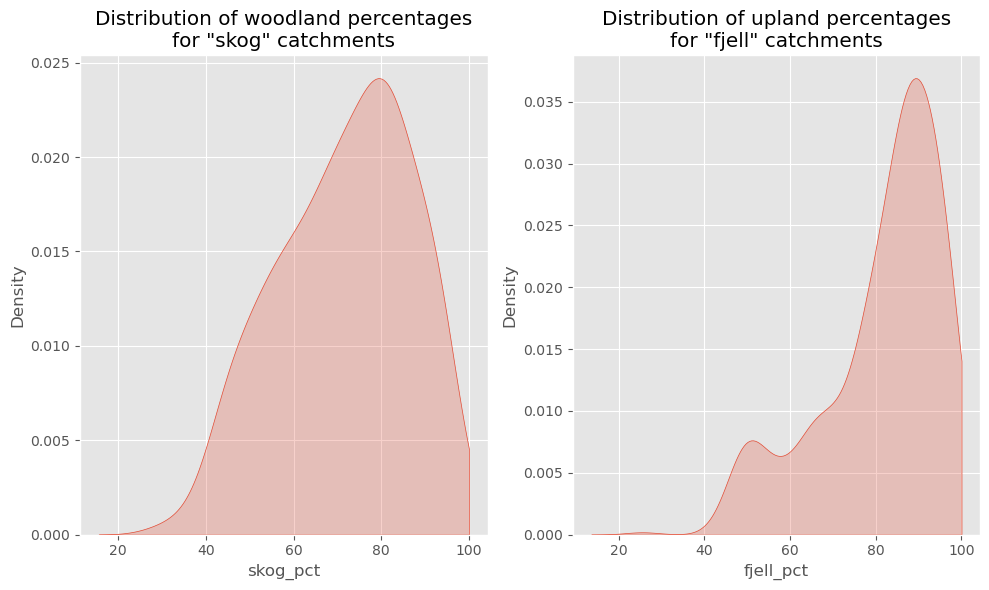

In [5]:
# Divide into "skog" and "fjell"
cat_gdf["fjell_pct"] = (
    100 * (cat_gdf["a_upland_km2"] + cat_gdf["a_glacier_km2"]) / cat_gdf["area_km2"]
)
cat_gdf["skog_pct"] = 100 * cat_gdf["a_wood_km2"] / cat_gdf["area_km2"]
skog_gdf = cat_gdf.query("skog_pct > fjell_pct")
fjell_gdf = cat_gdf.query("skog_pct < fjell_pct")

print(
    f"There are {len(skog_gdf)} catchments in the 'skog' dataset "
    f"and {len(fjell_gdf)} catchments in the 'fjell' dataset."
)

# Plot distributions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sn.kdeplot(data=skog_gdf, x="skog_pct", ax=axes[0], fill=True, clip=(0, 100))
sn.kdeplot(data=fjell_gdf, x="fjell_pct", ax=axes[1], fill=True, clip=(0, 100))
axes[0].set_title('Distribution of woodland percentages\nfor "skog" catchments')
axes[1].set_title('Distribution of upland percentages\nfor "fjell" catchments')
plt.tight_layout()

This seems OK, although the number of "skog" catchments is a bit low for robust interpolation. I was hoping for a more even split, but `len(cat_gdf.query("skog_pct > 30"))` shows there are only 286 catchments in the dataset with more than 30% woodland, so I don't think changing the selection criteria will help much.

## 3. Checking for outliers

Check the water chemistry data for obvious issues that might affect interpolation.

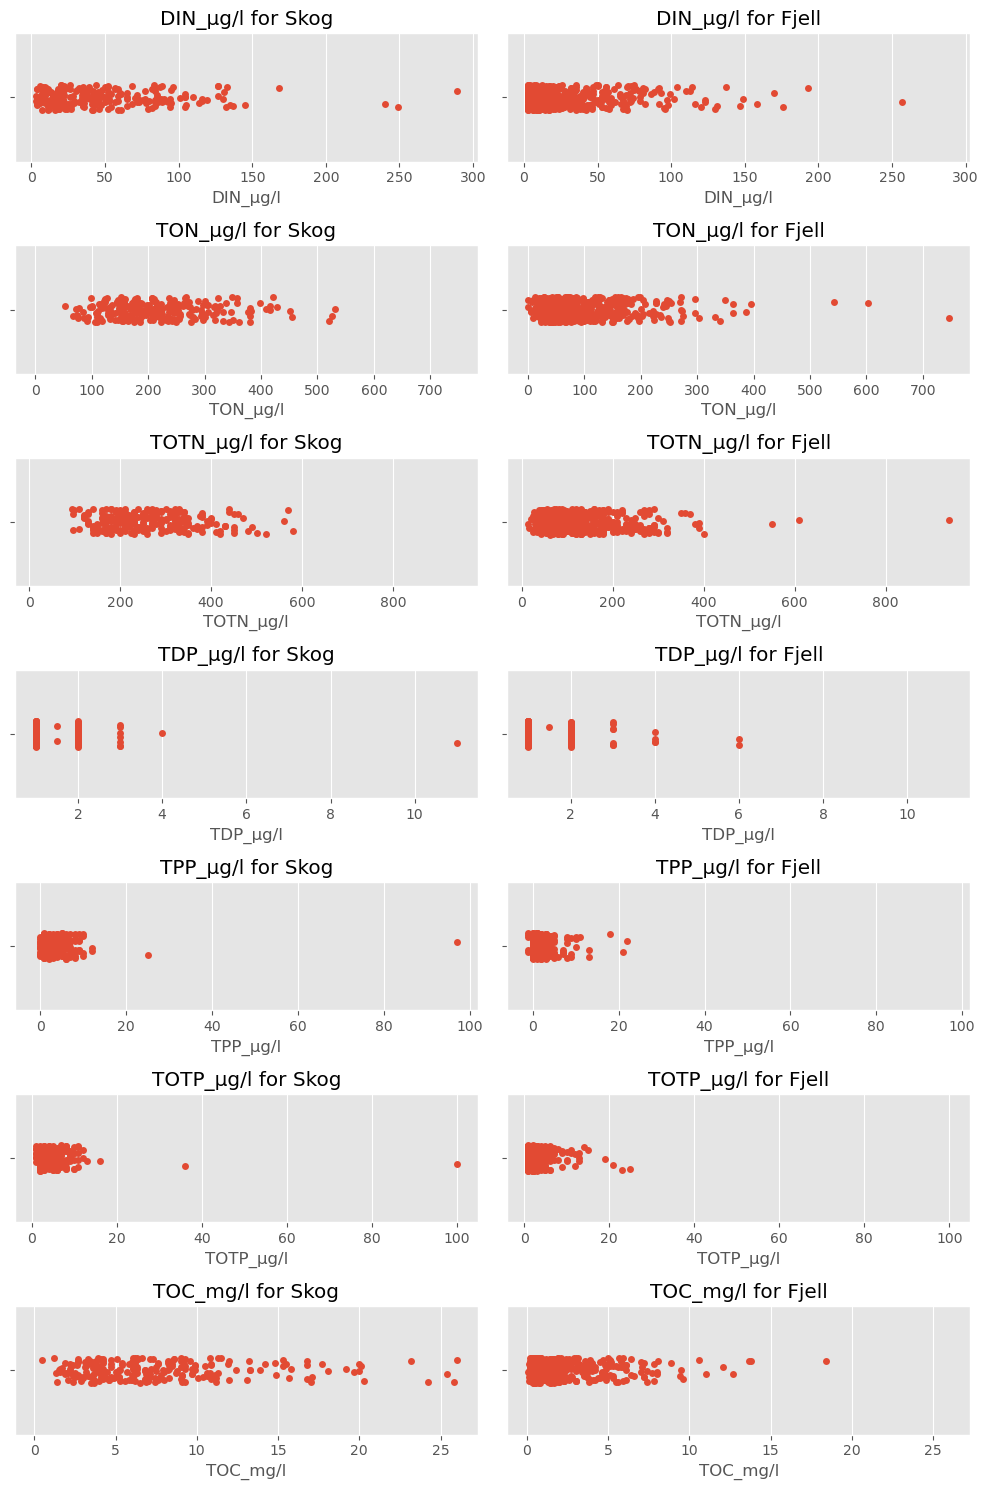

In [6]:
pars = [
    "DIN_µg/l",
    "TON_µg/l",
    "TOTN_µg/l",
    "TDP_µg/l",
    "TPP_µg/l",
    "TOTP_µg/l",
    "TOC_mg/l",
]

fig, axes = plt.subplots(nrows=len(pars), ncols=2, sharex="row", figsize=(10, 15))
for idx, par in enumerate(pars):
    sn.stripplot(x=skog_gdf[par], ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{par} for Skog")

    sn.stripplot(x=fjell_gdf[par], ax=axes[idx, 1])
    axes[idx, 1].set_title(f"{par} for Fjell")

plt.tight_layout()

Based on these plots, I think it is reasonable to remove the following points from the dataset before interpolating:

 * DIN >200 ug/l (4 points)
 * TOTN in fjell areas >500 ug/l (3 points). Note that these values also create outliers for TON, which makes them extra suspicious
 * TDP for skog areas >10 ug/l (1 point)
 * TOTP for skog areas > 30 ug/l (2 points). There is one value of ~100 ug/l, which is clearly too high, and one of ~35 ug/l. The latter could be reasonable in an area underlain by P-rich clay, but checking shows this value comes from Ulvøyvatn in Lofoten, which has igneous bedrock
 
In total, I will therefore remove 10 data points as unrealistic outliers.

776 points in dataset after removing outliers.


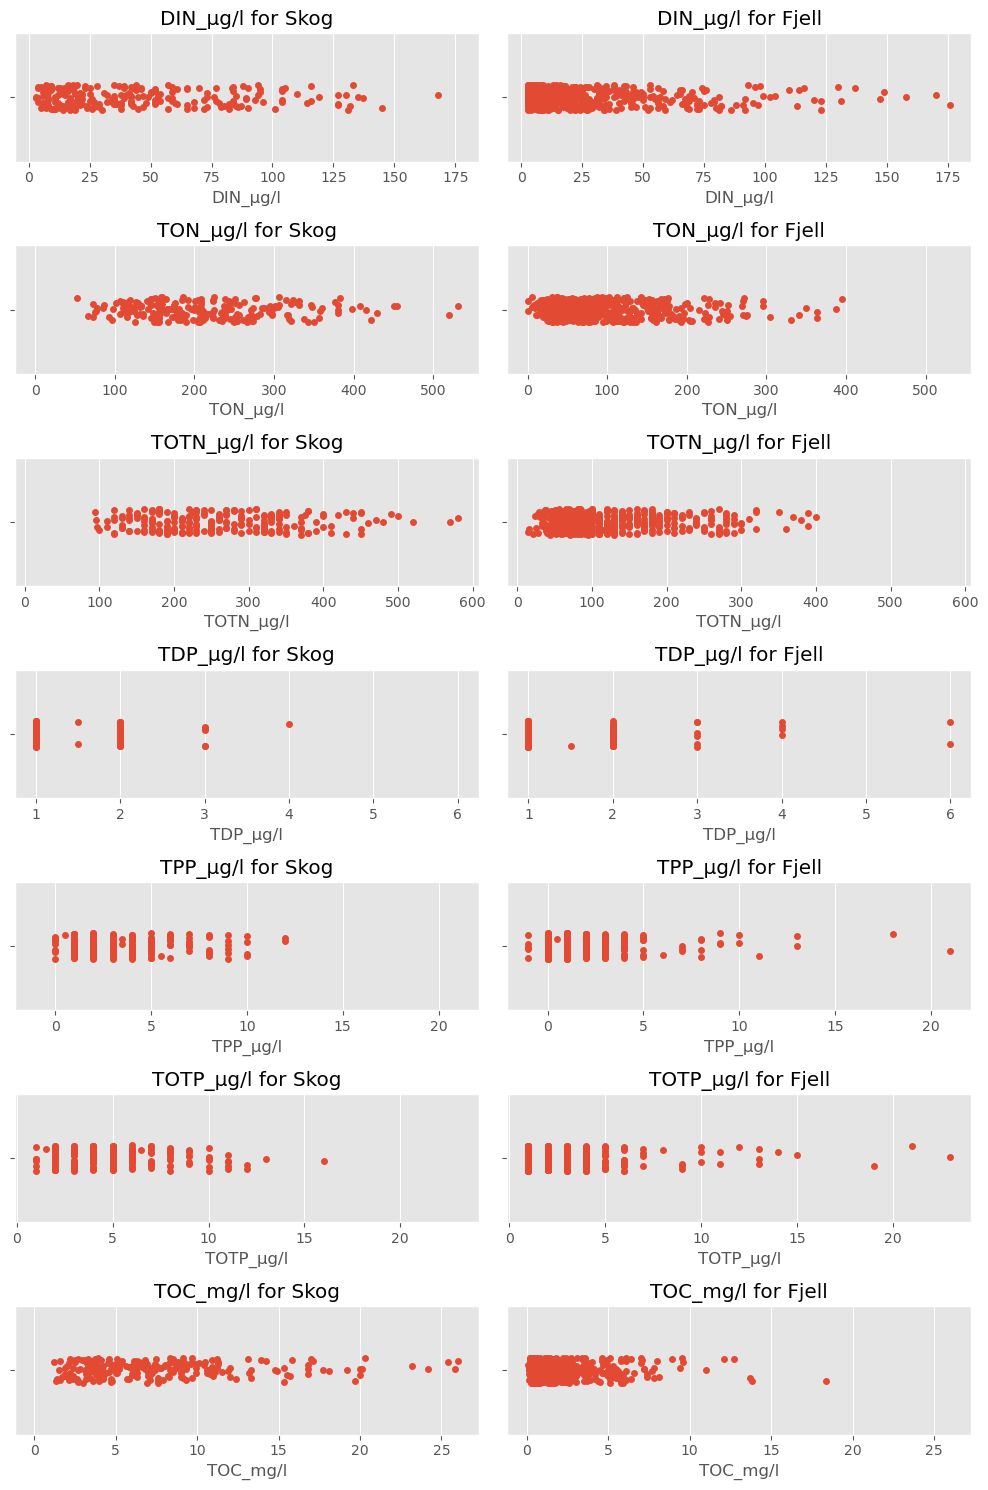

In [7]:
# Filter outliers
skog_gdf = skog_gdf[skog_gdf["DIN_µg/l"] <= 200]
skog_gdf = skog_gdf[skog_gdf["TDP_µg/l"] <= 10]
skog_gdf = skog_gdf[skog_gdf["TOTP_µg/l"] <= 30]
fjell_gdf = fjell_gdf[fjell_gdf["DIN_µg/l"] <= 200]
fjell_gdf = fjell_gdf[fjell_gdf["TOTN_µg/l"] <= 500]

print(len(skog_gdf) + len(fjell_gdf), "points in dataset after removing outliers.")

# Check distributions look more reasonable
fig, axes = plt.subplots(nrows=len(pars), ncols=2, sharex="row", figsize=(10, 15))
for idx, par in enumerate(pars):
    sn.stripplot(x=skog_gdf[par], ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{par} for Skog")

    sn.stripplot(x=fjell_gdf[par], ax=axes[idx, 1])
    axes[idx, 1].set_title(f"{par} for Fjell")

plt.tight_layout()

## 4. Compare summary statistics to the original TEOTIL data

After some searching, I found a Word document from 2004 on NIVA's network describing the original procedure in more detail (the file is currently archived in NIVA's Doksenter [here](https://niva365.sharepoint.com/:f:/r/sites/company/22/l72/Fra%20K/Tidligere%20prosjekter/O-13255-TEOTIL/Bakgrunnskoeffisienter?csf=1&web=1&e=wce67q)). The following quote is from this file:

> Middelverdien for alle observasjonspunktene i skog var 3.0 µg/l totP og 177 µg/l totN. For fjellområder var de tilsvarende konsentrasjonene 2.9 µg/l og 149 µg/l. Dvs. samme fosforverdi for begge arealtypene og noe større nitrogenverdi for skog. Som et utgangspunkt kunne vi benyttet disse koeffisienten for hele landet. Eventuelt kun brukt en koeffisient for som gjaldt all utmark, både skog- og fjellområder, på 3.0 µg totP/l og 165 µg/l totN. I det endelige utvalget var midlere innsjøareal 0.4 km2 og nedbørfeltareal henholdsvis 7 km2

Before interpolating anything, let's compare this to the updated values.

In [8]:
print("Mean values for 'skog':")
print(f"  TOTP: {skog_gdf['TOTP_µg/l'].mean():.1f} µg/l")
print(f"  TOTN: {skog_gdf['TOTN_µg/l'].mean():.1f} µg/l")
print("")
print("Mean values for 'fjell':")
print(f"  TOTP: {fjell_gdf['TOTP_µg/l'].mean():.1f} µg/l")
print(f"  TOTN: {fjell_gdf['TOTN_µg/l'].mean():.1f} µg/l")
print("")
print(f"Mean catchment area: {cat_gdf['area_km2'].mean():.1f} km2")

Mean values for 'skog':
  TOTP: 4.7 µg/l
  TOTN: 261.0 µg/l

Mean values for 'fjell':
  TOTP: 2.5 µg/l
  TOTN: 117.2 µg/l

Mean catchment area: 4.6 km2


Based on this, values for "fjell" are slightly lower than those in the old data, while mean concentrations for "skog" seem substantially higher. The mean catchment size in the new dataset is also smaller.

## 5. Spatial interpolation

The original TEOTIL model used Inverse Distance Weighting (IDW) with the number of neighbours considered equal to 12 and the decay exponent set to 1. However, these parameters were chosen arbitrarily and further manual adjustments were made afterwards to remove unrealistic artifacts.

For the new model, I would like to use cross-validation to make a more principled choice of spatial interpolation parameters.

Note that **I will not interpolate grids for TON and TPP**, since these are derived parameters in the raw data. For consistency I will therefore also derive them in the interpolated datasets (e.g. by estimating a grid for TON as gridded TOTN minus DIN).

In [9]:
# Link water chem to outflow points, not catchments
cols = ["station_id", "area_km2"] + pars
skog_pt_gdf = stn_gdf.merge(skog_gdf[cols], how="left", on="station_id").dropna(
    subset="area_km2"
)
fjell_pt_gdf = stn_gdf.merge(fjell_gdf[cols], how="left", on="station_id").dropna(
    subset="area_km2"
)
assert len(skog_pt_gdf) == len(skog_gdf)
assert len(fjell_pt_gdf) == len(fjell_gdf)

# Ignore TON and TPP during interpolation
pars = [
    "DIN_µg/l",
    "TOTN_µg/l",
    "TDP_µg/l",
    "TOTP_µg/l",
    "TOC_mg/l",
]

### 5.1. Plot raw data

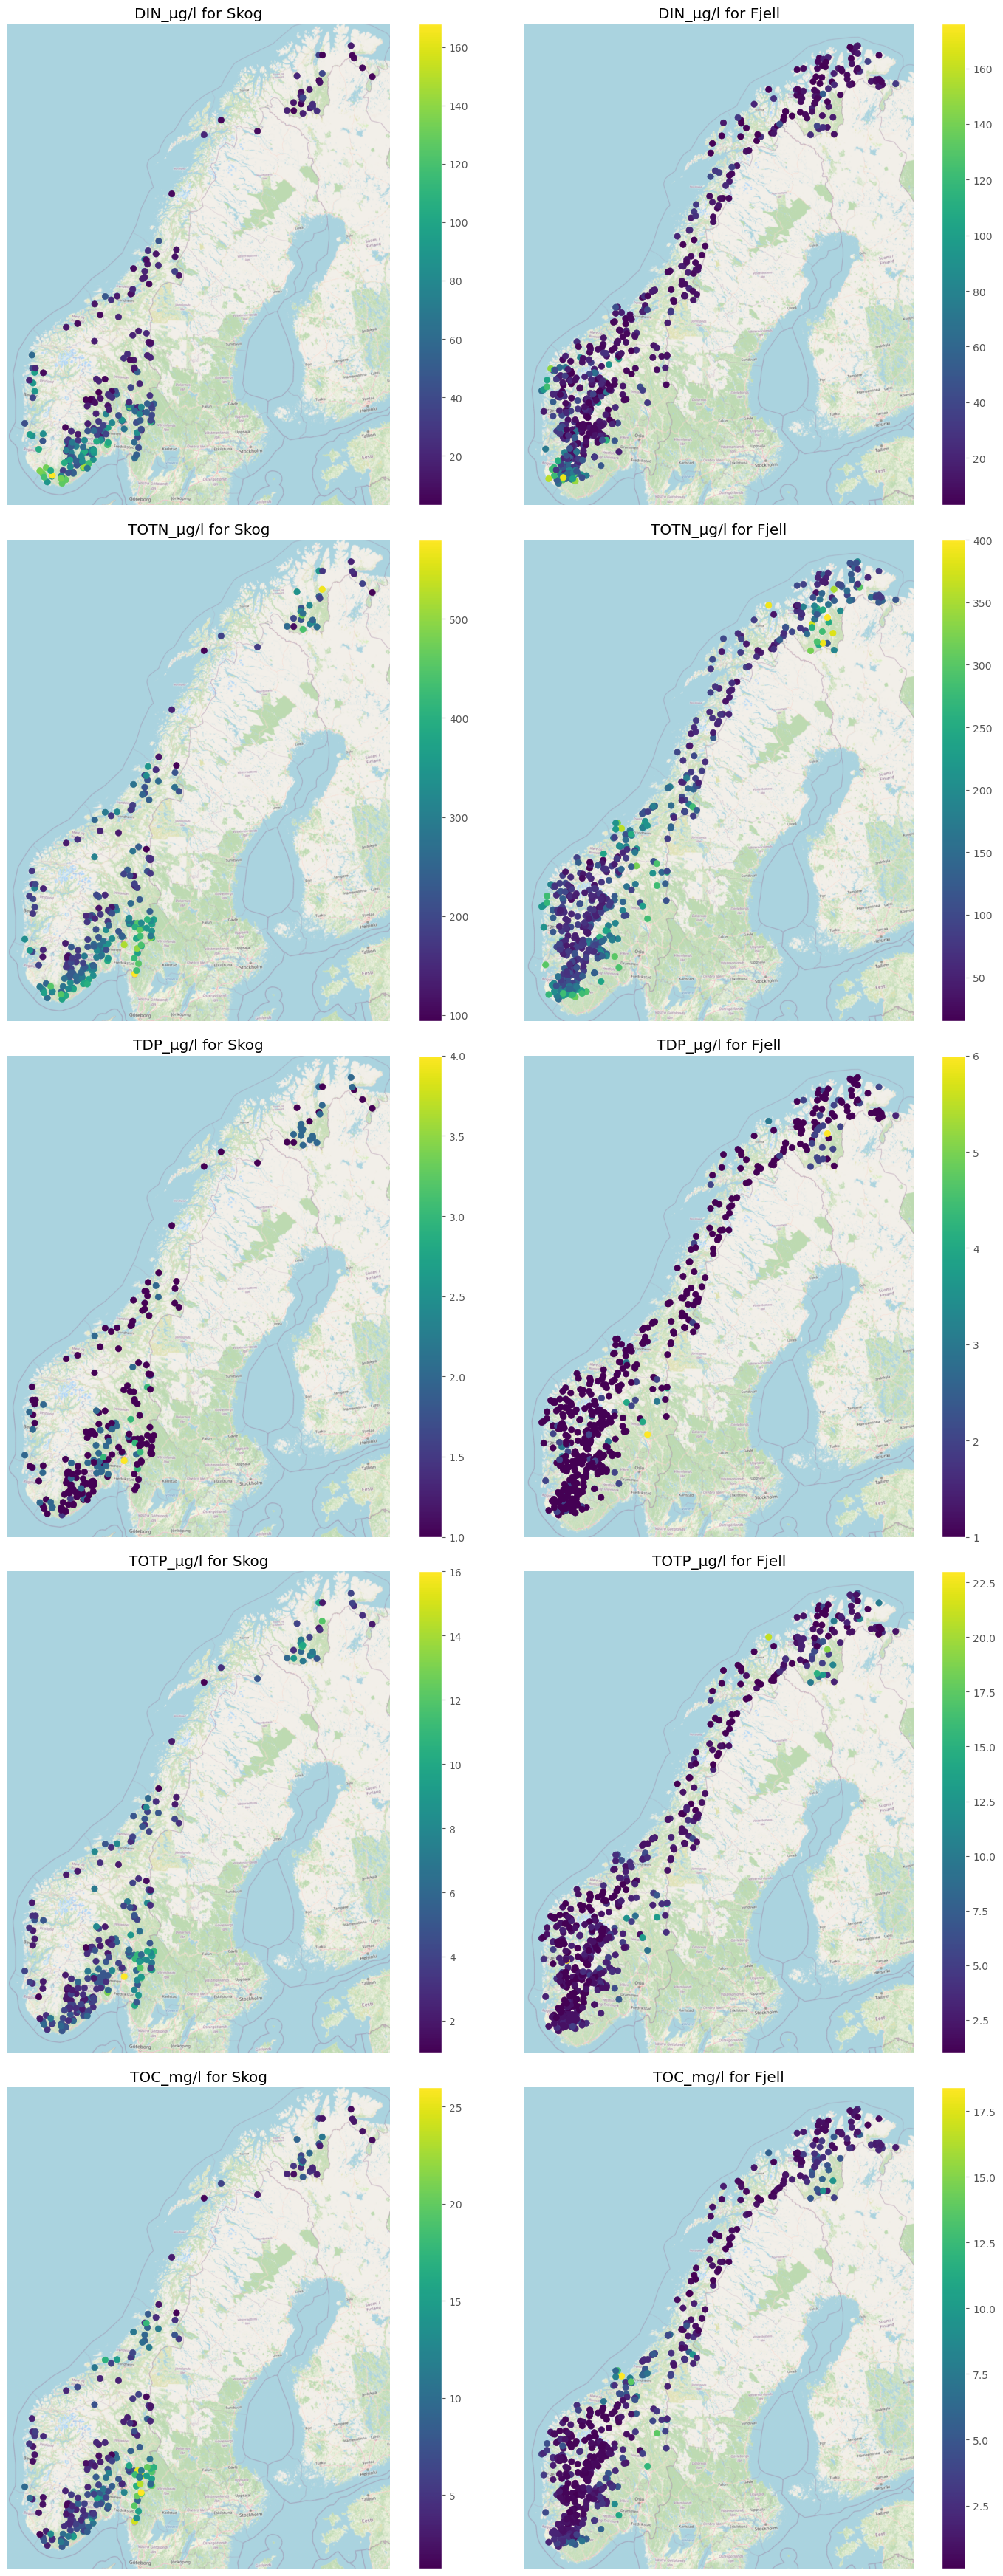

In [10]:
# Plot
fig, axes = plt.subplots(nrows=len(pars), ncols=2, figsize=(15, 35))
for idx, par in enumerate(pars):
    skog_pt_gdf.plot(ax=axes[idx, 0], column=par, legend=True)
    cx.add_basemap(
        axes[idx, 0],
        crs=skog_pt_gdf.crs.to_string(),
        attribution=False,
        source=cx.providers.OpenStreetMap.Mapnik,
    )
    axes[idx, 0].set_title(f"{par} for Skog")
    axes[idx, 0].axis("off")

    fjell_pt_gdf.plot(ax=axes[idx, 1], column=par, legend=True)
    cx.add_basemap(
        axes[idx, 1],
        crs=fjell_pt_gdf.crs.to_string(),
        attribution=False,
        source=cx.providers.OpenStreetMap.Mapnik,
    )
    axes[idx, 1].set_title(f"{par} for Fjell")
    axes[idx, 1].axis("off")

plt.tight_layout()

### 5.2. Spline interpolation

Using the [Verde](https://www.fatiando.org/verde/latest/index.html) package.

Verde includes some nice options for cross-validation, and well as "blocking" and detrending the data. Manual exploration of these options shows that "blocking" is worthwhile, but detrending is not. All models have been evaluated using 5-fold cross-validation with $R^2$ as the scoring metric.

In [11]:
# Interpolation options

# Grid/"block" raw data by taking the median?
block_reduce = True

# De-trend? 0 => Do not fit trend
trend_degree = 0

# Spline params for CV
dampings = [None, 1e-4, 1e-3, 1e-2, 1e-1, 1]
min_dists = [1e2, 1e3, 5e3, 10e3, 50e3, 100e3]
metric = "r2"

# Setup output grid
# Bounding box for Norway in ETRS89-based UTM zone 33N
west, east, south, north = -90000, 1140000, 6432000, 7951000
extent = (west, east, south, north)

# Output resolution in m
spacing = 1000

In [12]:
# Interpolate
coords = vd.grid_coordinates(region=extent, spacing=spacing, pixel_register=True)

gdf_dict = {"Skog": skog_pt_gdf, "Fjell": fjell_pt_gdf}
ds_list = []

for lc_class, gdf in gdf_dict.items():
    for par in pars:
        print(lc_class, par)

        # Build processing chain
        ops = []
        if block_reduce:
            ops.append(("reduce", vd.BlockReduce(np.median, spacing=spacing)))
        if trend_degree > 0:
            ops.append(("trend", vd.Trend(degree=trend_degree)))
        ops.append(
            (
                "spline_cv",
                vd.SplineCV(dampings=dampings, mindists=min_dists, scoring=metric),
            )
        )
        chain = vd.Chain(ops)

        chain.fit((gdf.geometry.x, gdf.geometry.y), gdf[par])

        print(
            "  R-squared after CV:",
            f"{chain.named_steps['spline_cv'].scores_.max():.2f}",
        )
        print("  Best damping:", chain.named_steps["spline_cv"].damping_)
        print("  Best min_dist:", chain.named_steps["spline_cv"].mindist_)

        # Predict grid points
        grid = chain.grid(coordinates=coords, data_names=f"{lc_class}_{par}")
        grid = vd.distance_mask(
            (gdf.geometry.x, gdf.geometry.y), maxdist=200e3, grid=grid
        )
        ds_list.append(grid)

# Merge to xarray dataset
ds = xr.merge(ds_list)

# # Calculate derived pars
# for lc_class in ["Skog", "Fjell"]:
#     ds[f"{lc_class}_TON_µg/l"] = (
#         ds[f"{lc_class}_TOTN_µg/l"] - ds[f"{lc_class}_DIN_µg/l"]
#     )
#     ds[f"{lc_class}_TPP_µg/l"] = (
#         ds[f"{lc_class}_TOTP_µg/l"] - ds[f"{lc_class}_TDP_µg/l"]
#     )

# Set negative values to 0
# i.e. keep values > 0  and NaNs, but set everything else to 0
ds = ds.where((ds > 0) | ds.isnull(), 0)

# Set spatial metadata to be compatible with GeoTIFF for use later
ds = ds.rename({"easting": "x", "northing": "y"})
ds = ds.rio.write_crs("epsg:25833")

# rasterstats can't handle arrays indexed with increasing 'y', like those
# generated by Verde. See
# https://github.com/perrygeo/python-rasterstats/issues/98
# Flip array and 'y' indices to make compatible
ds = ds.sel(y=slice(None, None, -1))
ds = ds.rio.write_transform()

ds

Skog DIN_µg/l
  R-squared after CV: 0.58
  Best damping: 0.001
  Best min_dist: 50000.0
Skog TOTN_µg/l
  R-squared after CV: 0.51
  Best damping: 0.0001
  Best min_dist: 5000.0
Skog TDP_µg/l
  R-squared after CV: 0.06
  Best damping: 0.01
  Best min_dist: 100000.0
Skog TOTP_µg/l
  R-squared after CV: 0.35
  Best damping: 0.001
  Best min_dist: 100.0
Skog TOC_mg/l
  R-squared after CV: 0.51
  Best damping: 0.001
  Best min_dist: 1000.0
Fjell DIN_µg/l
  R-squared after CV: 0.52
  Best damping: 0.001
  Best min_dist: 100000.0
Fjell TOTN_µg/l
  R-squared after CV: 0.53
  Best damping: 0.0001
  Best min_dist: 100000.0
Fjell TDP_µg/l
  R-squared after CV: 0.01
  Best damping: 0.001
  Best min_dist: 50000.0
Fjell TOTP_µg/l
  R-squared after CV: 0.20
  Best damping: 0.001
  Best min_dist: 50000.0
Fjell TOC_mg/l
  R-squared after CV: 0.52
  Best damping: 0.0001
  Best min_dist: 100000.0


<xarray.Dataset>
Dimensions:          (y: 1519, x: 1230)
Coordinates:
  * x                (x) float64 -8.95e+04 -8.85e+04 ... 1.138e+06 1.14e+06
  * y                (y) float64 7.95e+06 7.95e+06 ... 6.434e+06 6.432e+06
    spatial_ref      int64 0
Data variables:
    Skog_DIN_µg/l    (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Skog_TOTN_µg/l   (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Skog_TDP_µg/l    (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Skog_TOTP_µg/l   (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Skog_TOC_mg/l    (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Fjell_DIN_µg/l   (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Fjell_TOTN_µg/l  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Fjell_TDP_µg/l   (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Fjell_TOTP_µg/l  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Fjell_TOC_mg/l   (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    metadata:  Generated by Chain(steps=[('reduce',\n              BlockReduc...

**Interpolation seems to work fairly well for all parameters except TDP, which cannot be predicted reliably. I'm not sure why this is - consider options for improving?**

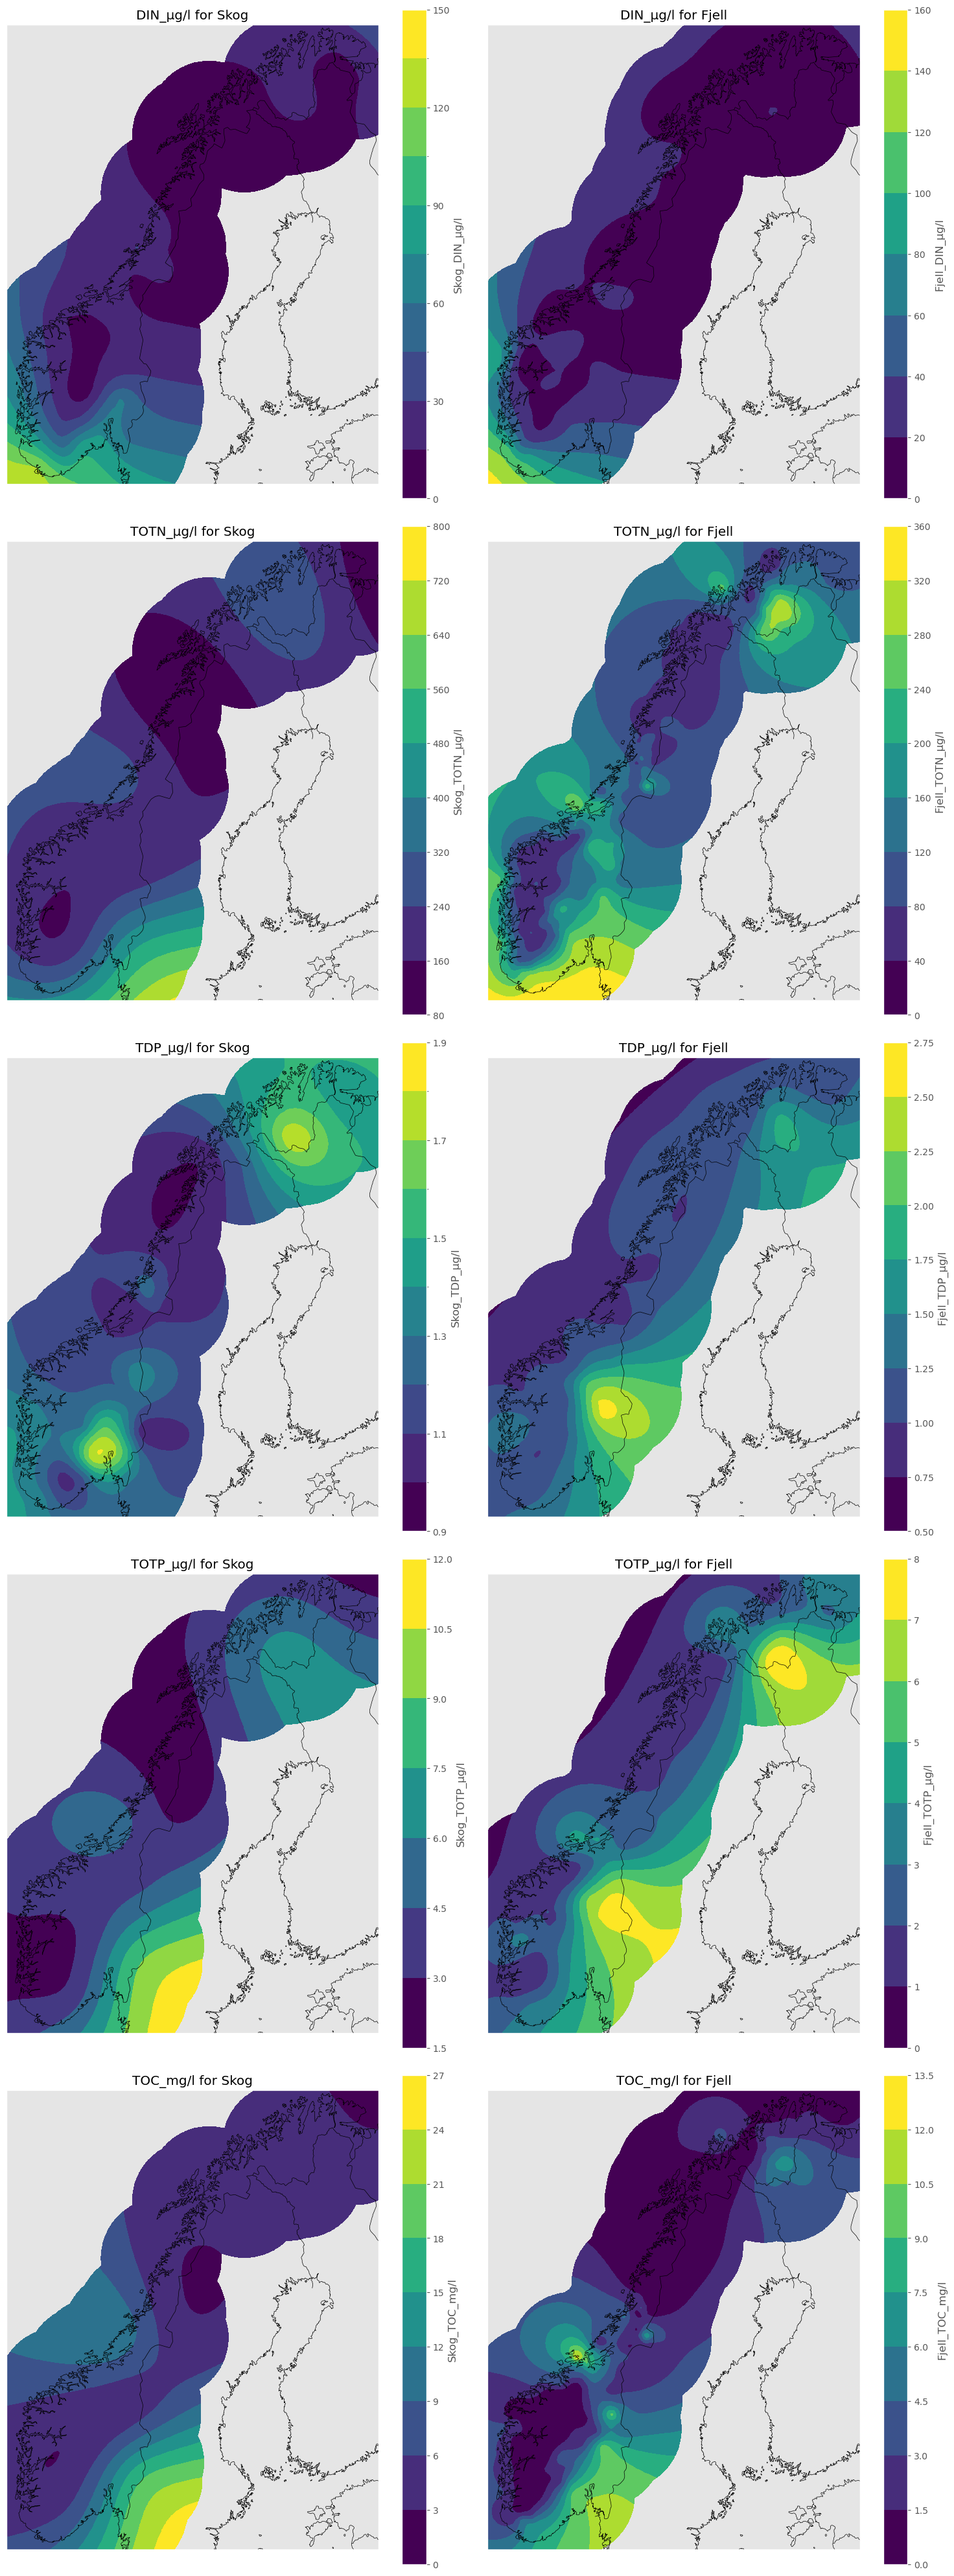

In [13]:
# Setup axes
crs = ProjectCustomExtent(epsg=25833, extent=extent)
fig, axes = plt.subplots(
    ncols=2, nrows=len(pars), figsize=(15, 40), subplot_kw={"projection": crs}
)

# Plot
for idx, par in enumerate(pars):
    # Skog
    axes[idx, 0].set_extent(extent, crs=crs)
    ds[f"Skog_{par}"].plot(transform=crs, ax=axes[idx, 0], levels=10)
    axes[idx, 0].add_feature(cfeature.BORDERS)
    axes[idx, 0].coastlines()
    axes[idx, 0].set_title(f"{par} for Skog")

    # Fjell
    axes[idx, 1].set_extent(extent, crs=crs)
    ds[f"Fjell_{par}"].plot(transform=crs, ax=axes[idx, 1], levels=10)
    axes[idx, 1].add_feature(cfeature.BORDERS)
    axes[idx, 1].coastlines()
    axes[idx, 1].set_title(f"{par} for Fjell")

plt.tight_layout()

## 6. Zonal statistics

The code below calculates the mean value in each regine for each parameter and land class.

In [14]:
# Read tidied regine data
data_fold = r"/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_gdf = gpd.read_file(teo_gpkg, layer="regines", driver="GPKG")

# Get just relevant columns
cols = [
    "regine",
    "vassom",
    "geometry",
]
reg_gdf = reg_gdf[cols]
reg_gdf.head()

regine vassom                                           geometry
0    001.10    001  MULTIPOLYGON (((297006.830 6543966.950, 297169...
1   001.1A1    001  MULTIPOLYGON (((297505.440 6543157.790, 297543...
2  001.1A20    001  MULTIPOLYGON (((297770.368 6543429.036, 297787...
3  001.1A2A    001  MULTIPOLYGON (((299678.370 6544460.320, 299667...
4  001.1A2B    001  MULTIPOLYGON (((303353.460 6552989.330, 303341...

In [15]:
ndv = -9999
stats = [
    "mean",
]

for lc_class, gdf in gdf_dict.items():
    for par in pars:
        print(lc_class, par)

        da = ds[f"{lc_class}_{par}"]
        da = da.fillna(ndv)
        da.rio.write_nodata(ndv, inplace=True)
        da.rio.to_raster(
            "temp.tif",
            compress="lzw",
        )

        stats_df = pd.DataFrame(
            zonal_stats(
                vectors=reg_gdf,
                raster="temp.tif",
                stats=stats,
                all_touched=True,
            )
        )
        reg_gdf[f"{lc_class}_{par}"] = stats_df["mean"]

os.remove("temp.tif")

# Round
reg_gdf = reg_gdf.round(1)

# Calculate derived pars
for lc_class in ["Skog", "Fjell"]:
    reg_gdf[f"{lc_class}_TON_µg/l"] = (
        reg_gdf[f"{lc_class}_TOTN_µg/l"] - reg_gdf[f"{lc_class}_DIN_µg/l"]
    )
    reg_gdf[f"{lc_class}_TPP_µg/l"] = (
        reg_gdf[f"{lc_class}_TOTP_µg/l"] - reg_gdf[f"{lc_class}_TDP_µg/l"]
    )

# Rename cols for compatibility with rest of workflow
for col in reg_gdf.columns:
    new_col = col.lower()
    if new_col.startswith("skog"):
        new_col = new_col.replace("skog", "wood")
    if new_col.startswith("fjell"):
        new_col = new_col.replace("fjell", "upland")
    reg_gdf.rename({col: new_col}, axis="columns", inplace=True)

# Save
out_csv = r"../../data/spatially_variable_background_coefficients.csv"
cols = [i for i in reg_gdf.columns if i not in ("vassom", "geometry")]
reg_df = reg_gdf[cols]
reg_df.to_csv(out_csv, index=False)
reg_gdf.head()

Skog DIN_µg/l
Skog TOTN_µg/l
Skog TDP_µg/l
Skog TOTP_µg/l
Skog TOC_mg/l
Fjell DIN_µg/l
Fjell TOTN_µg/l
Fjell TDP_µg/l
Fjell TOTP_µg/l
Fjell TOC_mg/l


regine vassom                                           geometry  \
0    001.10    001  MULTIPOLYGON (((297006.830 6543966.950, 297169...   
1   001.1A1    001  MULTIPOLYGON (((297505.440 6543157.790, 297543...   
2  001.1A20    001  MULTIPOLYGON (((297770.368 6543429.036, 297787...   
3  001.1A2A    001  MULTIPOLYGON (((299678.370 6544460.320, 299667...   
4  001.1A2B    001  MULTIPOLYGON (((303353.460 6552989.330, 303341...   

   wood_din_µg/l  wood_totn_µg/l  wood_tdp_µg/l  wood_totp_µg/l  \
0           67.8           498.8            1.3             8.4   
1           68.0           500.6            1.3             8.4   
2           67.6           500.7            1.3             8.4   
3           67.4           504.4            1.3             8.5   
4           65.5           500.9            1.3             8.5   

   wood_toc_mg/l  upland_din_µg/l  upland_totn_µg/l  upland_tdp_µg/l  \
0           17.7             56.6             317.6              1.8   
1           17.7             56.8             318.0              1.8   
2           17.7             56.6             317.6              1.8   
3           17.9             56.8             317.7              1.8   
4           17.9             55.4             315.2              1.8   

   upland_totp_µg/l  upland_toc_mg/l  wood_ton_µg/l  wood_tpp_µg/l  \
0               5.7             10.9          431.0            7.1   
1               5.7             10.9          432.6            7.1   
2               5.7             10.9          433.1            7.1   
3               5.7             10.9          437.0            7.2   
4               5.8             10.9          435.4            7.2   

   upland_ton_µg/l  upland_tpp_µg/l  
0            261.0              3.9  
1            261.2              3.9  
2            261.0              3.9  
3            260.9              3.9  
4            259.8              4.0

/opt/conda/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 6.
  warnings.warn(


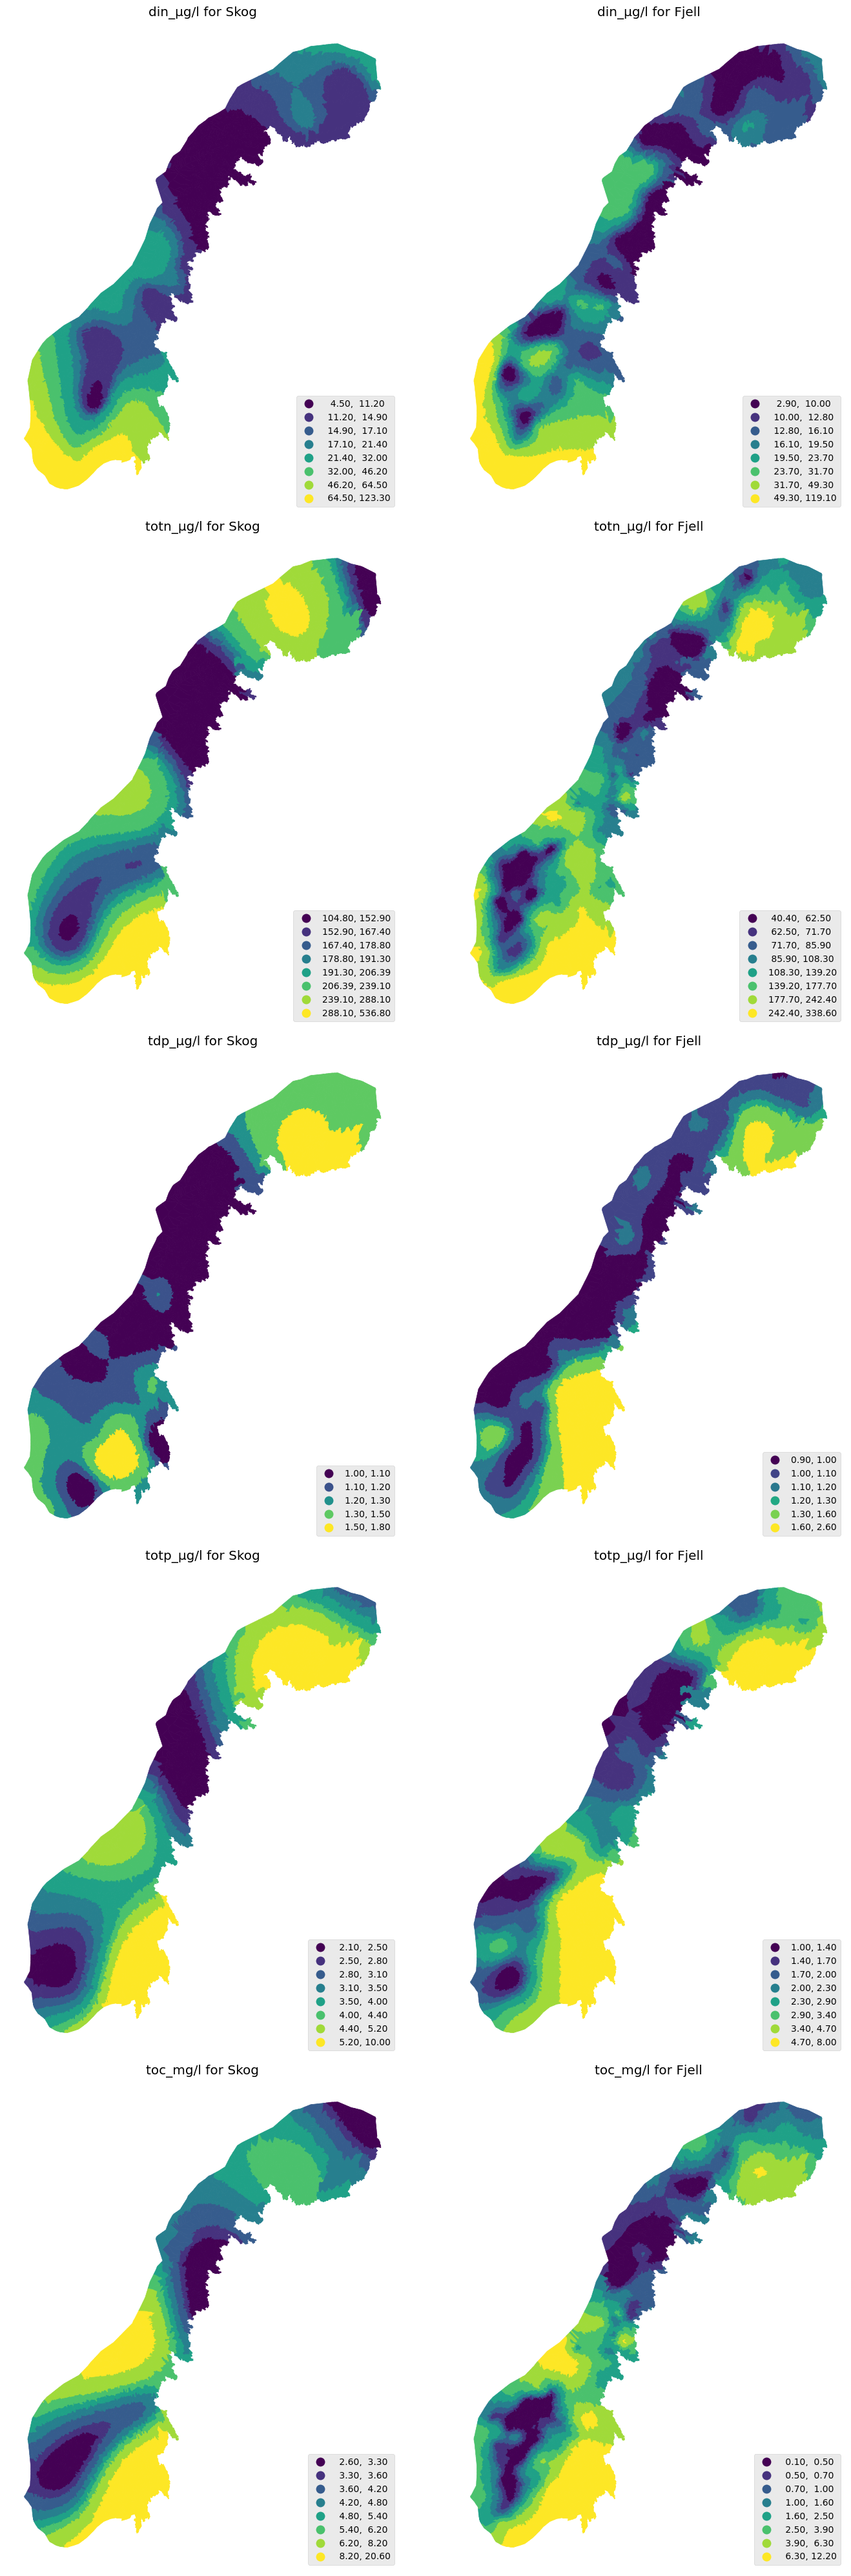

In [16]:
# Plot
fig, axes = plt.subplots(ncols=2, nrows=len(pars), figsize=(15, 40))
for idx, par in enumerate(pars):
    par = par.lower()

    # Skog
    reg_gdf.plot(
        column=f"wood_{par}",
        ax=axes[idx, 0],
        legend=True,
        scheme="quantiles",
        edgecolor="face",
        legend_kwds={"loc": "lower right"},
        classification_kwds={"k": 8},
    )
    axes[idx, 0].set_title(f"{par} for Skog")
    axes[idx, 0].axis("off")

    # Fjell
    reg_gdf.plot(
        column=f"upland_{par}",
        ax=axes[idx, 1],
        legend=True,
        scheme="quantiles",
        edgecolor="face",
        legend_kwds={"loc": "lower right"},
        classification_kwds={"k": 8},
    )
    axes[idx, 1].set_title(f"{par} for Fjell")
    axes[idx, 1].axis("off")

plt.tight_layout()